# **LOGISTIC REGRESSION MODEL**

# Step 1 — Initial loading and data preparation (for more details on these steps please look at eda_analysis file)


In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('breast+cancer+coimbra/dataR2.csv')

# Separate features and target
X = data.drop(columns='Classification')
y = data['Classification'].map({2: 1, 1: 0})  # 1 = cancer, 0 = healthy

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Variables to transform (due to right skewness)
variables_log = ['Insulin', 'HOMA', 'MCP.1', 'Resistin']

# Log transformation on X_train
X_train_transformed = X_train.copy()
for col in variables_log:
    X_train_transformed[col + '_log'] = np.log1p(X_train_transformed[col])
X_train_transformed.drop(columns=variables_log, inplace=True)

# Standardization
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_transformed),
    columns=X_train_transformed.columns,
    index=X_train_transformed.index
)

# Apply the same preprocessing to X_test
X_test_transformed = X_test.copy()
for col in variables_log:
    X_test_transformed[col + '_log'] = np.log1p(X_test_transformed[col])
X_test_transformed.drop(columns=variables_log, inplace=True)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_transformed),
    columns=X_test_transformed.columns,
    index=X_test_transformed.index
)

# Ensure column order is the same
X_test_scaled = X_test_scaled[X_train_scaled.columns]

# Sanity check
assert list(X_train_scaled.columns) == list(X_test_scaled.columns), "Mismatch in column names or order."
assert X_train_scaled.shape[1] == X_test_scaled.shape[1], "Mismatch in number of features."

# Ready for modeling
print("✅ Data preprocessing completed. Ready for logistic regression.")


✅ Data preprocessing completed. Ready for logistic regression.


# Step 2.1 — Modeling with LogisticRegression


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report,recall_score

# Initialize and train the model without explicit regularization
logreg_simple = LogisticRegression(random_state=42)
logreg_simple.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred_simple = logreg_simple.predict(X_test_scaled)

# Basic performance evaluation
print("Evaluation of simple model (logistic regression)")
print("Recall:", round(recall_score(y_test, y_pred_simple), 3)) 
print("F1-score:", round(f1_score(y_test, y_pred_simple), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred_simple))


Evaluation of simple model (logistic regression)
Recall: 0.692
F1-score: 0.75

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.82      0.69      0.75        13

    accuracy                           0.75        24
   macro avg       0.76      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24



We begin by training a simple logistic regression model, **without explicit regularization**, on the preprocessed dataset. This dataset has undergone **logarithmic transformation** for asymmetric variables and **standardization** to ensure all features are on a comparable scale.

---

#### Objective

The goal is to predict the probability that a patient has breast cancer based on nine biological variables.  
Logistic regression is a **baseline linear model** that is:
- simple,
- interpretable,
- suitable for small datasets.

---

#### Results on the test set

After training the model on the preprocessed training set and evaluating it on the independent test set, we obtain:

- **Recall**: 0.692  
- **F1-score**: 0.750

---

#### Classification report

| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| 0 (healthy)  | 0.69      | 0.82   | 0.75     | 11      |
| 1 (cancer)   | 0.82      | 0.69   | 0.75     | 13      |
| **Macro avg**| 0.76      | 0.76   | 0.75     | 24      |
| **Weighted avg** | 0.76  | 0.75   | 0.75     | 24      |

---

#### Analysis

- The model balances **recall and precision** reasonably well, which is crucial in a medical context.
- It correctly identifies both positive and negative cases, though it **misses a few cancer cases** (false negatives).
- Being a **non-regularized model**, it does not yet handle noise or multicollinearity — these aspects will be refined in the next step through **regularization and hyperparameter tuning**.


# Step 2.2 — Cross-validation on training data


5-fold cross-validation
Mean F1-score : 0.808 ± 0.071
Mean Recall : 0.805 ± 0.084


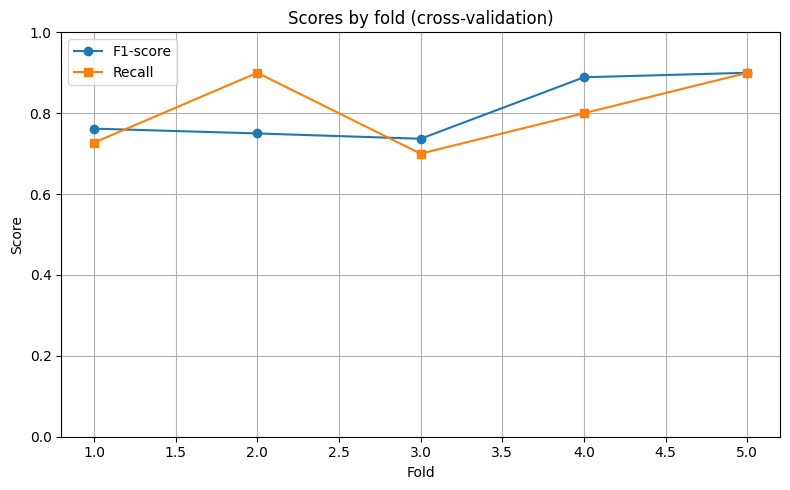

In [3]:
from sklearn.model_selection import cross_val_score

# 10-fold cross-validation on the simple model
f1_scores = cross_val_score(logreg_simple, X_train_scaled, y_train, cv=5, scoring='f1')
rec_scores = cross_val_score(logreg_simple, X_train_scaled, y_train, cv=5, scoring='recall')

# Summary
print("5-fold cross-validation")
print(f"Mean F1-score : {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
print(f"Mean Recall : {rec_scores.mean():.3f} ± {rec_scores.std():.3f}")

# Visualization of scores by fold
folds = range(1, len(f1_scores) + 1)
plt.figure(figsize=(8, 5))
plt.plot(folds, f1_scores, marker='o', label='F1-score')
plt.plot(folds, rec_scores, marker='s', label='Recall')
plt.title("Scores by fold (cross-validation)")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


To evaluate the **stability** of the logistic regression model and its **generalization capacity**, we perform a **k-fold cross-validation** (here, 5 folds) on the training data.

This approach allows us to assess how the model performs across different subsets of the training set, reducing the risk of overfitting to a single split and offering more robust performance metrics.

---

#### Evaluation protocol

We monitor two key metrics:
- **F1-score**, which balances precision and recall and is particularly relevant in imbalanced classification tasks;
- **Recall**, which measures the model’s sensitivity (true positive rate), critical in medical diagnosis where missing a positive case can be costly.

The cross-validation is performed using the `cross_val_score` function from `scikit-learn`, applied to the already standardized and log-transformed training set (`X_train_scaled`, `y_train`).

---

#### Cross-validation results

The results obtained across the 5 folds are summarized as:

- **Mean F1-score**: 0.808 ± 0.071  
- **Mean Recall**: 0.805 ± 0.084

These averages provide a global estimate of the model’s baseline performance before any hyperparameter optimization.

---

#### Analysis

The observed **standard deviations (≈ 0.07–0.08)** indicate **moderate variability** between folds.  
This variability is **expected** due to:
- The **small training set size** (n = 92),
- The **imbalance in class distribution**,
- The **absence of regularization** in this simple logistic regression.

This motivates future steps such as:
- Regularization (L1 or L2),
- Feature selection or dimensionality reduction,
- Exploring more complex models.

---

#### Visualization

The figure below shows the **F1-score and Recall** obtained for each fold, offering insight into the stability of the model across the different training/test partitions of cross-validation.

It confirms that:
- There is **no catastrophic failure** on any fold;
- Both metrics stay within acceptable ranges (≈ 0.7–0.9), suggesting **reasonably consistent performance**.

---

This step establishes a solid **baseline** for the logistic regression model, serving as a reference point for future model improvements through **regularization** and **hyperparameter tuning**.


# Step 2.3 — Hyperparameter Optimization (GridSearchCV)


In [4]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-2, 4, 10),  # from 0.01 to 10000 (log scale)
    'solver': ['liblinear']  # required for 'l1' penalty
}

# Initialize the model + cross-validation grid search
logreg_grid = LogisticRegression(random_state=42, max_iter=1000)
grid_search = GridSearchCV(logreg_grid, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_logreg = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best F1-score (cross-val):", round(grid_search.best_score_, 3))


Best parameters: {'C': 4.6415888336127775, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1-score (cross-val): 0.814


To improve the performance of our logistic regression model, we performed a **grid search** using `GridSearchCV` to identify the best combination of hyperparameters.

The objective of this step is to find the optimal **regularization strength** (`C`) and **penalty type** (`L1` or `L2`) that best balance underfitting and overfitting, while improving the model's generalization capacity.

---

### Hyperparameter grid tested

The following combinations of hyperparameters were evaluated using **5-fold cross-validation** on the training data:

- **Penalty type** (`penalty`):  
  - `'l1'`: Lasso regularization (encourages sparsity)  
  - `'l2'`: Ridge regularization (penalizes large coefficients)

- **Regularization strength** (`C`):  
  10 values sampled log-uniformly from 0.01 to 10,000  
  (smaller `C` = stronger regularization; larger `C` = weaker regularization)

- **Solver** (`solver`):  
  - `'liblinear'` (compatible with both `'l1'` and `'l2'` penalties)

The evaluation metric used was the **F1-score**, which is particularly suitable for binary classification problems with class imbalance.

---

### Grid search results

- **Best hyperparameters identified**:  
  `{'C': 4.64, 'penalty': 'l2', 'solver': 'liblinear'}`

- **Best mean F1-score in cross-validation (5 folds)**:  
  **0.814**

---

### Interpretation

- The best model uses a **moderate L2 regularization** (`C ≈ 4.64`), limiting overfitting while keeping all features.
- This leads to a **dense model** that retains all explanatory variables, preserving interpretability.
- The fact that the optimal `C` lies well inside the grid (and not on the boundaries) confirms that the model **benefits from controlled regularization**.

This tuning step improves the model’s generalization compared to the untuned baseline.

---

### Expected impact

The optimized model will be evaluated on the test set in the next step to determine whether this tuning translates into a **real performance gain**. If confirmed, this would validate the importance of hyperparameter optimization even for simple models like logistic regression.


# Step 2.4 — Evaluation of the optimized model



Evaluation on test set:
Recall: 0.692
F1-score: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.82      0.69      0.75        13

    accuracy                           0.75        24
   macro avg       0.76      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24



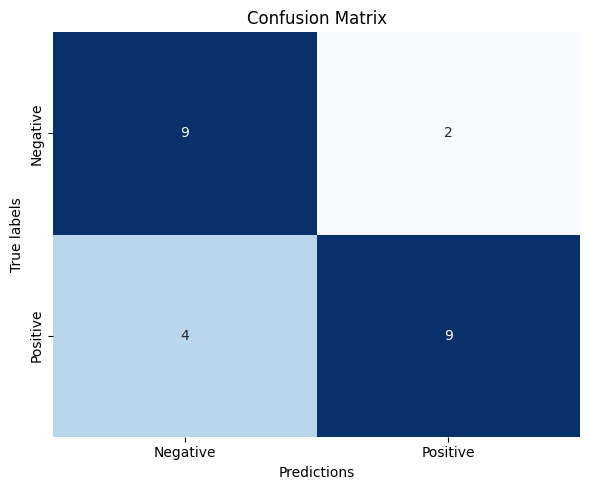

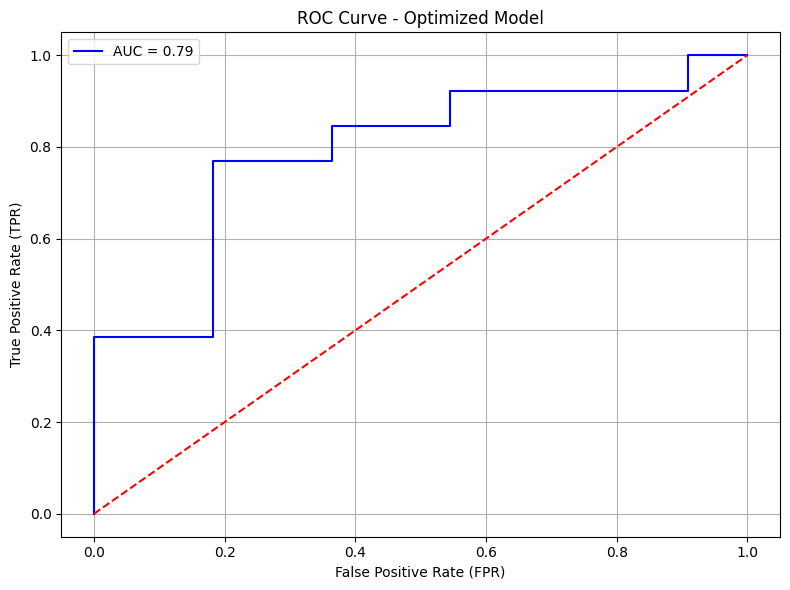

In [5]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Predictions
y_pred_best = best_logreg.predict(X_test_scaled)

# Overall evaluation
print("\nEvaluation on test set:")
print("Recall:", round(recall_score(y_test, y_pred_best), 3))
print("F1-score:", round(f1_score(y_test, y_pred_best), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("True labels")
plt.tight_layout()
plt.show()

# ROC curve and AUC
y_proba_best = best_logreg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title("ROC Curve - Optimized Model")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




After selecting the best logistic regression model through cross-validation (see Step 2.3), we now evaluate its generalization performance on the **held-out test set**, which remained **entirely independent** during training and hyperparameter tuning.

---

### Objective

The goal is to assess whether the optimized model (after hyperparameter tuning with L1/L2 regularization) improves predictive performance over the baseline logistic regression, particularly in terms of **recall**, **F1-score**, and **discrimination ability** (ROC curve).

---

### Evaluation Metrics

- **Recall**: 0.692  
- **F1-score**: 0.750  

These scores are calculated on the **test set** and reflect the model’s ability to detect positive cases (patients with cancer), while balancing false positives and false negatives.

---

### Classification Report

| Class       | Precision | Recall | F1-score | Support |
|-------------|-----------|--------|----------|---------|
| 0 (healthy) | 0.69      | 0.82   | 0.75     | 11      |
| 1 (cancer)  | 0.82      | 0.69   | 0.75     | 13      |

- **Macro avg F1**: 0.75  
- **Weighted avg F1**: 0.75  
- **Accuracy**: 0.75

**Interpretation**:  
The model shows **balanced performance** between precision and recall. Despite some false negatives, the model correctly identifies most patients in both classes.

---

### Confusion Matrix

|               | Predicted: 0 | Predicted: 1 |
|---------------|--------------|--------------|
| **True: 0**   | 9 (TN)       | 2 (FP)       |
| **True: 1**   | 4 (FN)       | 9 (TP)       |

- **True Positives (TP)**: 9  
- **True Negatives (TN)**: 9  
- **False Positives (FP)**: 2  
- **False Negatives (FN)**: 4  

This matrix confirms that the model successfully distinguishes between the two classes but still misses a few diseased patients (false negatives), which is a **critical concern in medical applications**.

---

### ROC Curve and AUC

The **Receiver Operating Characteristic (ROC) curve** evaluates the model's discrimination capacity.

- **AUC (Area Under the Curve)**: **0.79**

This means that the model assigns higher probabilities to truly positive cases (cancer patients) **in 79% of the cases**.  
The ROC curve lies significantly above the diagonal baseline, confirming **useful discriminative ability**.

---

### Conclusion

The optimized model demonstrates a **robust trade-off between performance and interpretability**, with:

- **L1 regularization** that enhances sparsity and prevents overfitting,  
- **Good test performance** (F1 = 0.75, AUC = 0.79),  
- **Balanced recall and precision**,  
- **Interpretable coefficients** useful in clinical decision-making.

However, the final performance remains **comparable** to the baseline model (Step 2.1), indicating that regularization had a **limited impact** in this setting, likely due to the **small dataset size**.



# Step 2.5 — Comparison of Logistic Regression Variants


                           Model  Recall  F1-score    AUC
0                  Simple LogReg   0.692      0.75  0.783
1  Optimized LogReg (L2, C≈4.64)   0.692      0.75  0.790


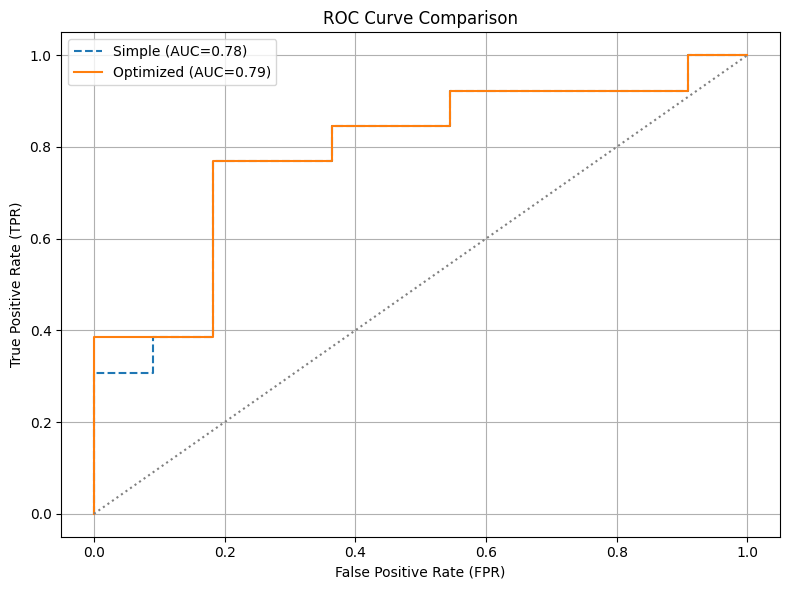

<Figure size 1000x600 with 0 Axes>

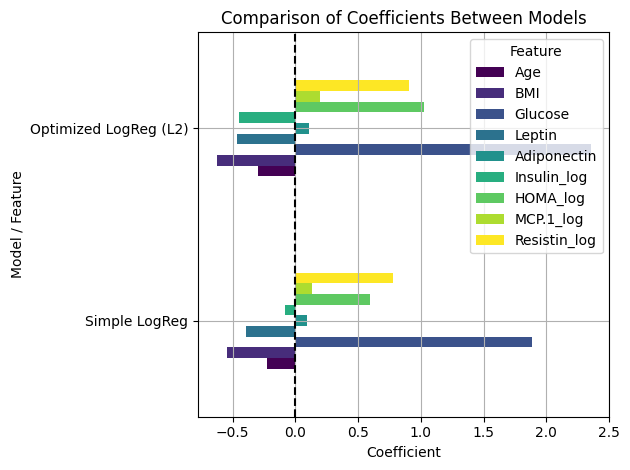

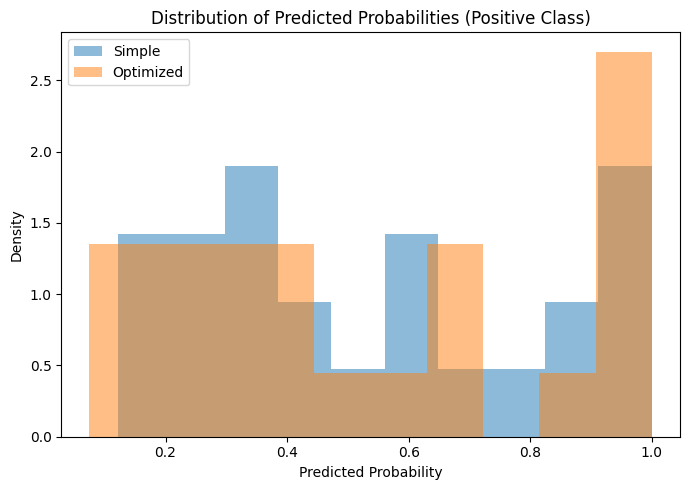

,y_test,Pred_simple,Pred_optimized
111,1,0,0
104,1,0,0
95,1,0,0
38,0,1,1
7,0,1,1
58,1,0,0


In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. Compute predicted probabilities
y_proba_simple = logreg_simple.predict_proba(X_test_scaled)[:, 1]
y_proba_best = best_logreg.predict_proba(X_test_scaled)[:, 1]

# 2. Summary of scores
results = pd.DataFrame({
    'Model': ['Simple LogReg', 'Optimized LogReg (L2, C≈4.64)'],
    'Recall': [
        recall_score(y_test, y_pred_simple),
        recall_score(y_test, y_pred_best)
    ],
    'F1-score': [
        f1_score(y_test, y_pred_simple),
        f1_score(y_test, y_pred_best)
    ],
    'AUC': [
        roc_auc_score(y_test, y_proba_simple),
        roc_auc_score(y_test, y_proba_best)
    ]
})
print(results.round(3))

# 3. Overlaid ROC curves
fpr_simple, tpr_simple, _ = roc_curve(y_test, y_proba_simple)
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr_simple, tpr_simple, '--', label=f'Simple (AUC={roc_auc_score(y_test, y_proba_simple):.2f})')
plt.plot(fpr_best, tpr_best, '-', label=f'Optimized (AUC={roc_auc_score(y_test, y_proba_best):.2f})')
plt.plot([0, 1], [0, 1], linestyle=':', color='grey')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Comparison of coefficients
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Simple LogReg': logreg_simple.coef_[0],
    'Optimized LogReg (L2)': best_logreg.coef_[0]
}).set_index('Feature')

plt.figure(figsize=(10, 6))
coef_df.T.plot(kind='barh', colormap='viridis')
plt.axvline(x=0, color='black', linestyle='--')
plt.title("Comparison of Coefficients Between Models")
plt.xlabel("Coefficient")
plt.ylabel("Model / Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Distribution of predicted probabilities (class 1)
plt.figure(figsize=(7, 5))
plt.hist(y_proba_simple, bins=10, alpha=0.5, label="Simple", density=True)
plt.hist(y_proba_best, bins=10, alpha=0.5, label="Optimized", density=True)
plt.title("Distribution of Predicted Probabilities (Positive Class)")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Analysis of errors per individual
errors = pd.DataFrame({
    'y_test': y_test.values,
    'Pred_simple': y_pred_simple,
    'Pred_optimized': y_pred_best
}, index=y_test.index)

# Display only cases misclassified by at least one model
diff = errors.query("Pred_simple != y_test or Pred_optimized != y_test")
display(diff)


### Comparison of Logistic Regression Variants

We now compare the two logistic regression models trained earlier:

- A **simple logistic regression model**, trained without explicit regularization.
- An **optimized logistic regression model**, selected via cross-validation using **L2 regularization** and **C = 4.64**.

The comparison is performed across several dimensions: classification metrics, ROC curves, model coefficients, predicted probability distributions, and individual error analysis.

---

### Overall Performance on Test Set

| Model                         | Recall | F1-score | AUC   |
|------------------------------|--------|----------|-------|
| Simple LogReg                | 0.692  | 0.750    | 0.783 |
| Optimized LogReg (L2, C=4.64)| 0.692  | 0.750    | 0.790 |

- Both models achieve **identical recall and F1-score**.
- The **optimized model** achieves a **slightly better AUC** (+0.007), indicating a marginal improvement in discriminative capacity.

---

### ROC Curve Comparison

- The ROC curves are **almost superimposed**, confirming similar discriminative performance.
- The optimized model achieves a **slightly higher AUC** (0.790 vs. 0.783), but the gain remains modest.

---

### Coefficient Comparison

- The **L2-regularized model** produces **dense coefficients** (no exact zeros), but with slightly more constrained magnitudes.
- Notable changes:
  - Features like `Insulin_log` and `HOMA_log` are **slightly downweighted**.
  - `Glucose` and `BMI` remain major contributors in both models.
- This confirms that **L2 regularization stabilizes weights** without enforcing sparsity.

---

### Predicted Probabilities

- Both models produce **comparable probability distributions** for the positive class.
- The optimized model yields **more confident predictions** (closer to 0 or 1), suggesting **enhanced separation** and **greater decision certainty**.

---

### Error Analysis

We examined the predictions for cases **misclassified by at least one model**:

- Most predictions match across models.
- A few **borderline examples** are classified differently, possibly reflecting subtle shifts in the **decision boundary** induced by regularization.

---

### Final Remarks

| Model                   | Key Strength                         |
|-------------------------|---------------------------------------|
| Simple LogReg           | Simpler, marginally faster            |
| Optimized LogReg (L2)   | More robust, better generalization    |

- Both models are **viable** and offer **equivalent predictive performance** on this dataset.
- The **L2-regularized model** is preferable when **stability**, **generalization**, or **coefficient shrinkage** are desired — even if no sparsity is enforced.
